In [4]:
import joblib
import matplotlib.pyplot as plt
import numpy as np


mlp = joblib.load("mlp_model.pkl")

/Users/livavandervelden/opt/anaconda3/envs/hcml/lib/python3.9/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LabelBinarizer from version 1.1.3 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/livavandervelden/opt/anaconda3/envs/hcml/lib/python3.9/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator MLPClassifier from version 1.1.3 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [5]:
from project import load_data


X_train, X_test, y_train, y_test = load_data()

alcohol
CL5    757
CL6    503
CL4    284
CL3    197
CL2     68
CL1     34
CL0     33
Name: count, dtype: int64
amphet
CL0    973
CL2    240
CL1    230
CL3    196
CL6    101
CL4     75
CL5     61
Name: count, dtype: int64
amyl
CL0    1298
CL2     236
CL1     210
CL3      91
CL4      24
CL5      14
CL6       3
Name: count, dtype: int64
benzos
CL0    999
CL3    234
CL2    229
CL4    119
CL1    116
CL6     95
CL5     84
Name: count, dtype: int64
caff
CL6    1379
CL5     271
CL4     106
CL3      59
CL0      27
CL2      24
CL1      10
Name: count, dtype: int64
cannabis
CL6    458
CL0    412
CL2    266
CL3    210
CL1    207
CL5    185
CL4    138
Name: count, dtype: int64
choc
CL6    805
CL5    679
CL4    295
CL3     53
CL0     32
CL2     10
CL1      2
Name: count, dtype: int64
coke
CL0    1035
CL2     267
CL3     257
CL1     160
CL4      98
CL5      40
CL6      19
Name: count, dtype: int64
crack
CL0    1621
CL2     109
CL1      67
CL3      59
CL5       9
CL4       9
CL6       2
Name: count, d

In [28]:
from lime.lime_tabular import LimeTabularExplainer

lime_explainer = LimeTabularExplainer(X_train.values, feature_names=X_train.columns, class_names=[0, 1], discretize_continuous=False)
lime_values = [dict(sorted(lime_explainer.explain_instance(x, mlp.predict_proba, num_features=12).as_list(), key=lambda x: x[0])) for x in X_test.values]

In [7]:
import shap

shap_explainer = shap.KernelExplainer(mlp.predict_proba, X_test)
shap_values = shap_explainer.shap_values(X_test)


/Users/livavandervelden/opt/anaconda3/envs/hcml/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Using 376 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
100%|██████████| 376/376 [01:36<00:00,  3.91it/s]


In [8]:
shap_values_positive = shap_values[:, :, 1]

In [9]:
import torch
import torch.nn as nn

class MLP(nn.Module):
    def __init__(self, mlp_model):
        super(MLP, self).__init__()
        self.hidden1 = nn.Linear(10, 32)
        self.hidden2 = nn.Linear(32, 16)
        self.output = nn.Linear(16, 1)  # Adjust output size based on your problem

        # Copy weights from the trained MLPClassifier
        self.hidden1.weight.data = torch.tensor(mlp_model.coefs_[0].T, dtype=torch.float32)
        self.hidden1.bias.data = torch.tensor(mlp_model.intercepts_[0], dtype=torch.float32)
        self.hidden2.weight.data = torch.tensor(mlp_model.coefs_[1].T, dtype=torch.float32)
        self.hidden2.bias.data = torch.tensor(mlp_model.intercepts_[1], dtype=torch.float32)
        self.output.weight.data = torch.tensor(mlp_model.coefs_[2].T, dtype=torch.float32)
        self.output.bias.data = torch.tensor(mlp_model.intercepts_[2], dtype=torch.float32)

    def forward(self, x):
        x = torch.sigmoid(self.hidden1(x))
        x = torch.sigmoid(self.hidden2(x))
        x = self.output(x)
        return x

# Create a PyTorch model from the scikit-learn model
torch_model = MLP(mlp)

In [10]:
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)

In [11]:
from captum.attr import LRP
import numpy as np

lrp = LRP(torch_model)

attributions = lrp.attribute(X_test_tensor)
attributions = attributions.detach().cpu().numpy()


/Users/livavandervelden/opt/anaconda3/envs/hcml/lib/python3.9/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(


In [12]:
lime_values_featureless = [list(val.values()) for val in lime_values]
lime_values_featureless[0]

[-0.02987432540203444,
 -0.08692736613782112,
 -0.05483870317475359,
 -0.015710564177938716,
 -0.02918904484015954,
 0.15681778954404665,
 0.17449725108398995]

In [13]:
import importlib
import evaluation
importlib.reload(evaluation)

lime_evaluations, lime_fpr, lime_tpr, lime_roc_auc = evaluation.run_evaluations(lime_values_featureless, y_test.values.ravel())

/Users/livavandervelden/opt/anaconda3/envs/hcml/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/livavandervelden/opt/anaconda3/envs/hcml/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/livavandervelden/opt/anaconda3/envs/hcml/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/livavandervelden/opt/anaconda3/envs/hcml/lib/python3.9/site-packages/

Best Hyperparameters: {'criterion': 'entropy', 'max_depth': 8, 'max_features': 'sqrt', 'n_estimators': 200}


In [14]:
shap_evaluations, shap_fpr, shap_tpr, shap_roc_auc = evaluation.run_evaluations(shap_values_positive, y_test.values.ravel())

/Users/livavandervelden/opt/anaconda3/envs/hcml/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/livavandervelden/opt/anaconda3/envs/hcml/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/livavandervelden/opt/anaconda3/envs/hcml/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/livavandervelden/opt/anaconda3/envs/hcml/lib/python3.9/site-packages/

Best Hyperparameters: {'criterion': 'gini', 'max_depth': 4, 'max_features': 'sqrt', 'n_estimators': 300}


In [15]:
lrp_evaluations, lrp_fpr, lrp_tpr, lrp_roc_auc = evaluation.run_evaluations(attributions, y_test.values.ravel())

/Users/livavandervelden/opt/anaconda3/envs/hcml/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/livavandervelden/opt/anaconda3/envs/hcml/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/livavandervelden/opt/anaconda3/envs/hcml/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:392: UserWarning: Exited at iteration 104 with accuracies 
[1.57456902e-15 6.15400152e-06 4.34375457e-06 4.25337277e-06]
not reaching the requested tolerance 5.602836608886719e-06.
Use iteration 104 instead with accuracy 
3.687782214209191e-06.

  _, diffusion_map = l

Best Hyperparameters: {'criterion': 'entropy', 'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 300}


In [16]:
lime_evaluations

,k,Silhouette Kmeans,Silhouette Spectral,DBI Kmeans,DBI Spectral
0,2,0.675080,-0.279969,0.648781,1.297623
1,3,0.556798,-0.289288,0.656261,1.288645
2,4,0.392241,-0.316396,0.817008,1.294475
3,5,0.305826,-0.377319,0.963951,1.270456
4,6,0.303106,-0.384297,0.953787,1.253137
5,7,0.266684,-0.413441,1.069346,1.324374
6,8,0.265564,-0.453973,1.062687,1.305203


In [17]:
shap_evaluations

,k,Silhouette Kmeans,Silhouette Spectral,DBI Kmeans,DBI Spectral
0,2,0.301294,-0.020328,1.368773,1.231795
1,3,0.304565,-0.036651,1.329310,2.610691
2,4,0.302124,-0.063489,1.262854,2.317925
3,5,0.235257,-0.075451,1.431792,1.419119
4,6,0.235623,-0.101693,1.405605,0.921875
5,7,0.190910,-0.094629,1.503518,0.896044
6,8,0.186850,-0.344728,1.494988,0.911032


In [18]:
lrp_evaluations

,k,Silhouette Kmeans,Silhouette Spectral,DBI Kmeans,DBI Spectral
0,2,0.991597,-0.605120,0.004313,1.818231
1,3,0.988411,-0.710349,0.004042,4.352631
2,4,0.981715,-0.606869,0.005390,9.398160
3,5,0.953635,-0.623466,0.146633,5.310944
4,6,0.912271,-0.564142,0.243031,10.958454
5,7,0.912036,-0.673329,0.226820,10.925499
6,8,0.908182,-0.635346,0.267161,10.623640


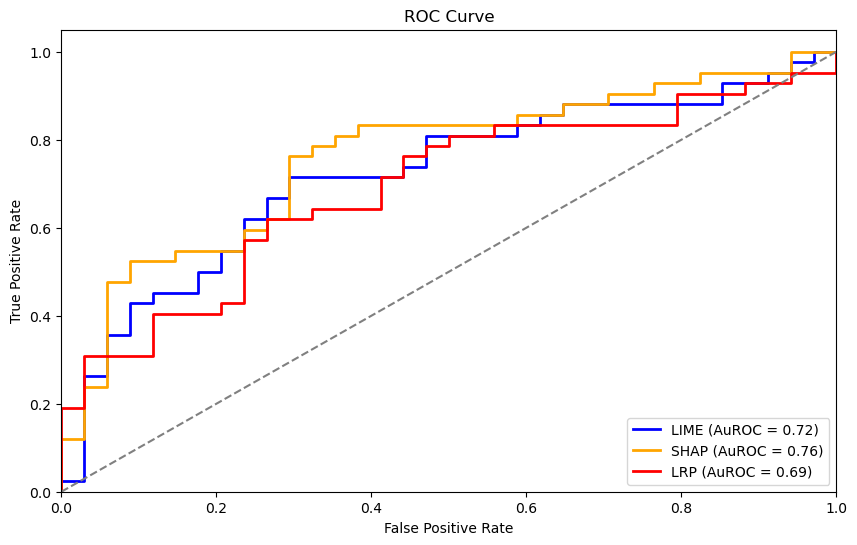

In [19]:

plt.figure(figsize=(10, 6))
plt.plot(lime_fpr, lime_tpr, color='blue', lw=2, label=f'LIME (AuROC = {lime_roc_auc:.2f})')
plt.plot(shap_fpr, shap_tpr, color='orange', lw=2, label=f'SHAP (AuROC = {shap_roc_auc:.2f})')
plt.plot(lrp_fpr, lrp_tpr, color='red', lw=2, label=f'LRP (AuROC = {lrp_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.savefig("ROC")
plt.show()

/Users/livavandervelden/opt/anaconda3/envs/hcml/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


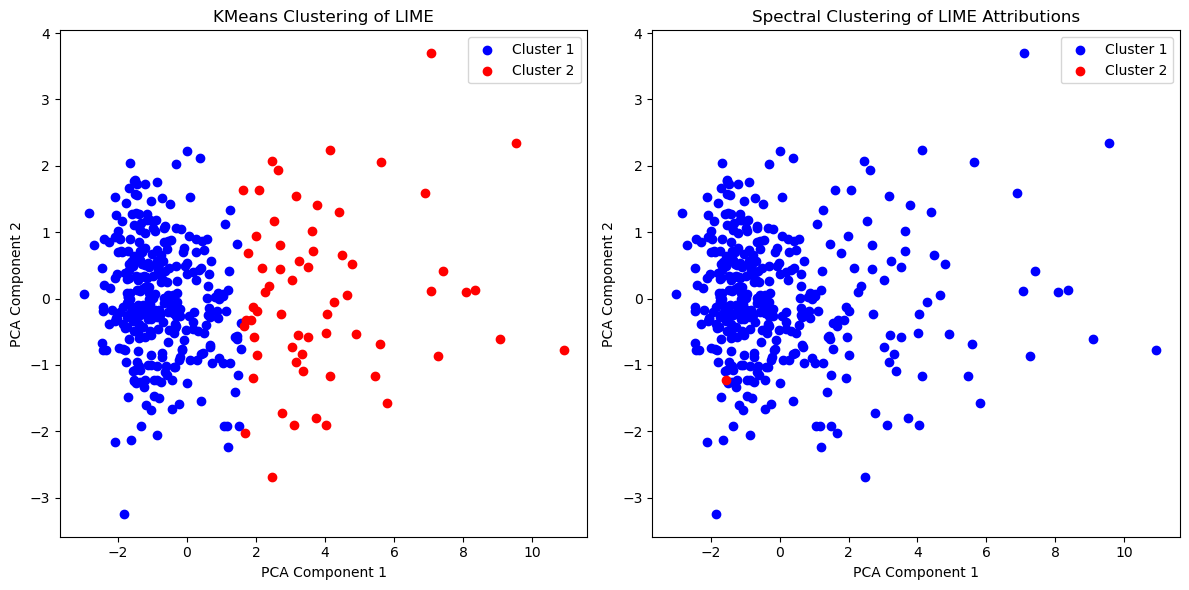

LIME clustering evaluation:
silhouette score (KMeans): 0.517
silhouette score (spectral): -0.280
DBI (KMeans): 0.859
DBI (spectral): 1.298


/Users/livavandervelden/opt/anaconda3/envs/hcml/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


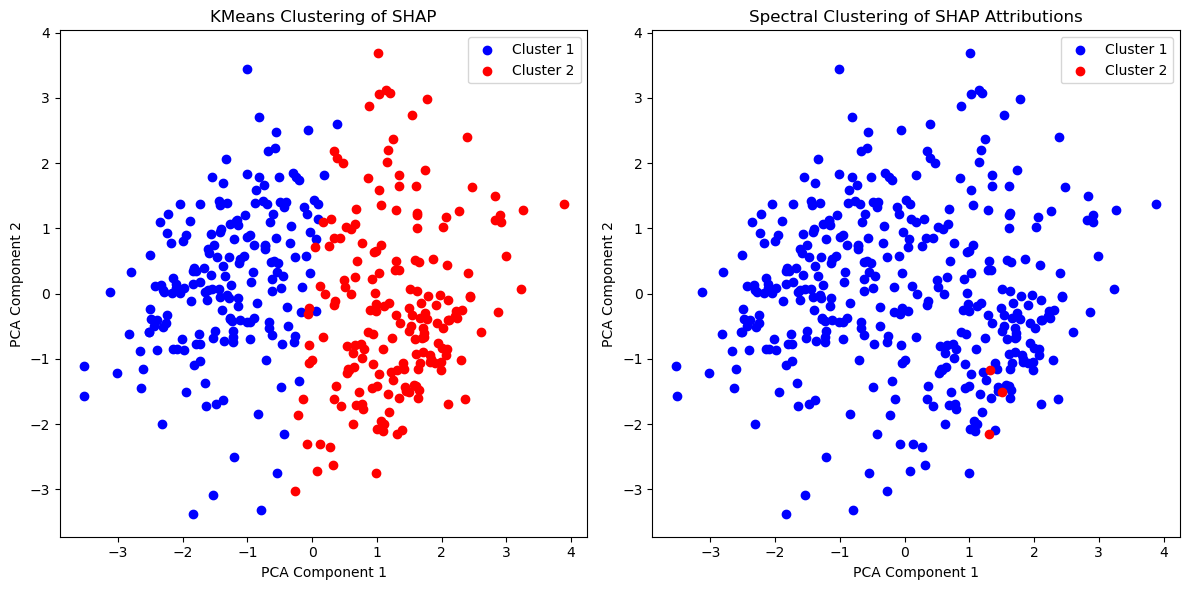

SHAP clustering evaluation:
silhouette score (KMeans): 0.235
silhouette score (spectral): -0.020
DBI (KMeans): 1.664
DBI (spectral): 1.232


/Users/livavandervelden/opt/anaconda3/envs/hcml/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/livavandervelden/opt/anaconda3/envs/hcml/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:392: UserWarning: Exited at iteration 68 with accuracies 
[1.04665754e-15 7.35014568e-06 5.28854719e-06]
not reaching the requested tolerance 5.602836608886719e-06.
Use iteration 61 instead with accuracy 
4.079683884443322e-06.

  _, diffusion_map = lobpcg(
/Users/livavandervelden/opt/anaconda3/envs/hcml/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:392: UserWarning: Exited postprocessing with accuracies 
[1.04161796e-15 5.38871420e-06 6.85033744e-06]
not reaching the requested tolerance 5.602836608886719e-06.
  _, diffusion_map = lobpcg(


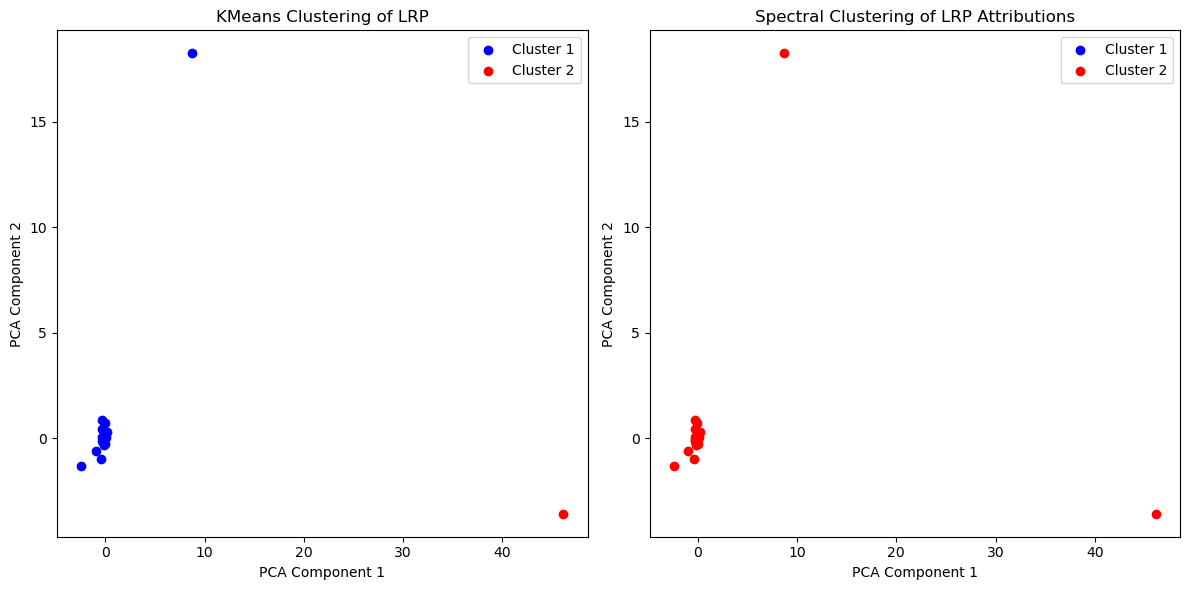

LRP clustering evaluation:
silhouette score (KMeans): 0.992
silhouette score (spectral): -0.621
DBI (KMeans): 0.003
DBI (spectral): 1.819


In [23]:
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, davies_bouldin_score

def clustering_and_eval(values, method_name):
    scaled_values = StandardScaler().fit_transform(values)
    pairwise_distances = squareform(pdist(scaled_values, "euclidean"))
    kmeans = KMeans(n_clusters=2, random_state=42).fit(scaled_values)
    kmeans_labels = kmeans.labels_
    spectral_clusters = SpectralClustering(n_clusters=2, affinity="precomputed", random_state=42).fit(pairwise_distances)
    spectral_labels = spectral_clusters.labels_
    pca = PCA(2)
    df = pca.fit_transform(scaled_values)

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    filtered_label0 = df[kmeans_labels == 0]
    filtered_label1 = df[kmeans_labels == 1]
    plt.scatter(filtered_label0[:, 0], filtered_label0[:, 1], color='blue', label='Cluster 1')
    plt.scatter(filtered_label1[:, 0], filtered_label1[:, 1], color='red', label='Cluster 2')
    plt.title(f'KMeans Clustering of {method_name}')
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.legend()

    plt.subplot(1, 2, 2)
    filtered_label0 = df[spectral_labels == 0]
    filtered_label1 = df[spectral_labels == 1]
    plt.scatter(filtered_label0[:, 0], filtered_label0[:, 1], color='blue', label='Cluster 1')
    plt.scatter(filtered_label1[:, 0], filtered_label1[:, 1], color='red', label='Cluster 2')
    plt.title(f'Spectral Clustering of {method_name} Attributions')
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.legend()

    plt.tight_layout()
    plt.show()

    #metrics
    silhouette_kmeans = silhouette_score(scaled_values, kmeans_labels)
    silhouette_spectral = silhouette_score(pairwise_distances, spectral_labels)
    dbi_kmeans = davies_bouldin_score(scaled_values, kmeans_labels)
    dbi_spectral = davies_bouldin_score(pairwise_distances, spectral_labels)
    print(f"{method_name} clustering evaluation:")
    print(f"silhouette score (KMeans): {silhouette_kmeans:.3f}")
    print(f"silhouette score (spectral): {silhouette_spectral:.3f}")
    print(f"DBI (KMeans): {dbi_kmeans:.3f}")
    print(f"DBI (spectral): {dbi_spectral:.3f}")

clustering_and_eval(lime_values_featureless, "LIME")
clustering_and_eval(shap_values_positive, "SHAP")
clustering_and_eval(attributions, "LRP")

## Single explanation


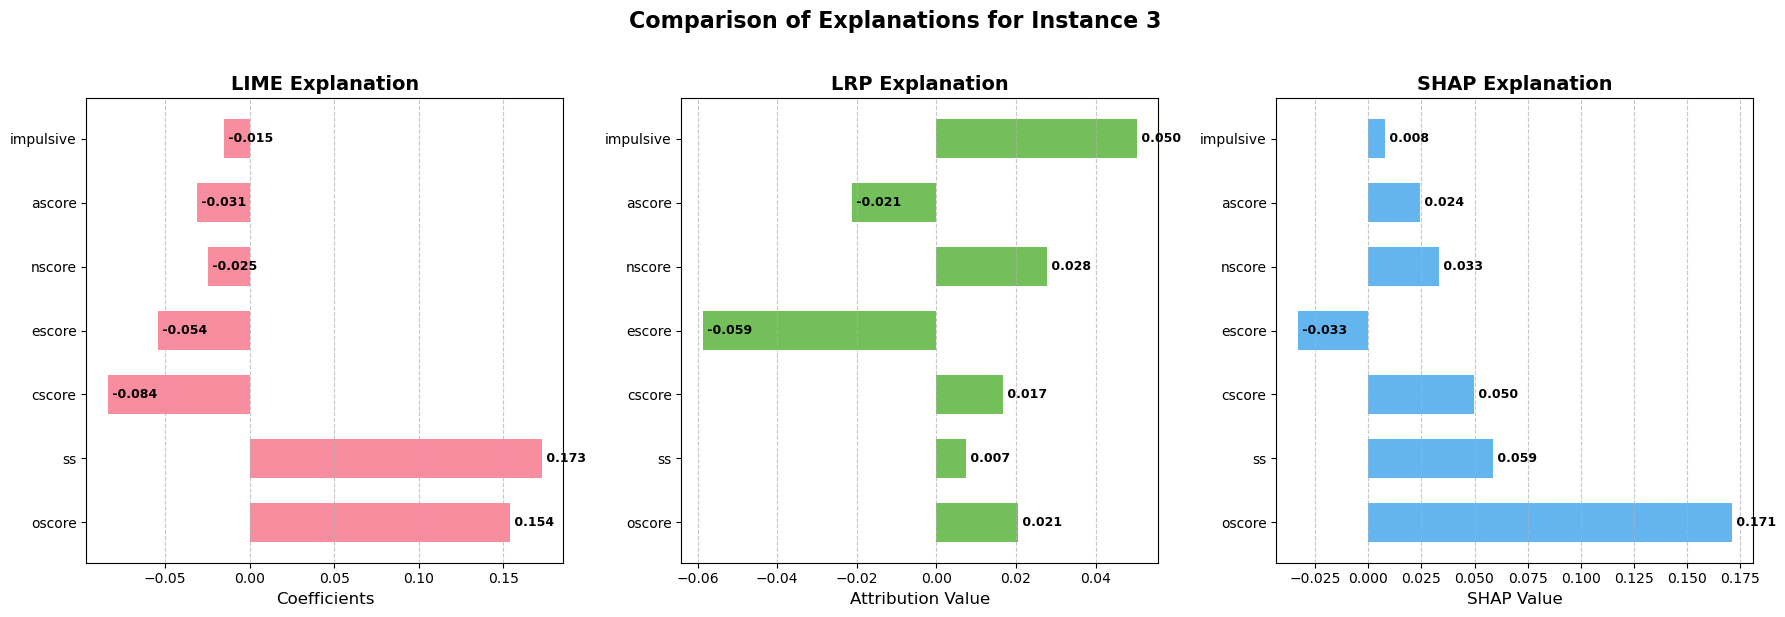

In [51]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

colors = sns.color_palette("husl", 3)

# indicate the instance 
instance_index = 3

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))
plt.subplots_adjust(wspace=0.3)

# pretty plot 
def pretty_barh(ax, values, labels, title, xlabel, color):
    y_pos = np.arange(len(labels))
    ax.barh(y_pos, values, align='center', color=color, alpha=0.8, height=0.6)
    ax.set_yticks(y_pos)
    ax.set_yticklabels(labels, fontsize=10)
    ax.set_xlabel(xlabel, fontsize=12)
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.grid(axis='x', linestyle='--', alpha=0.7)
    for i, v in enumerate(values):
        ax.text(v, i, f' {v:.3f}', va='center', fontsize=9, fontweight='bold')


lime_explanation = lime_explainer.explain_instance(X_test.values[instance_index], mlp.predict_proba, num_features=len(X_test.columns))
lime_dict = dict(lime_explanation.as_list())

instance_attribution = attributions[instance_index]
lrp_dict = dict(zip(X_train.columns, instance_attribution))

instance_shap_values = shap_values_positive[instance_index]
shap_dict = dict(zip(X_test.columns, instance_shap_values))

feature_importance = {}
for feature in X_test.columns:
    lime_value = abs(lime_dict.get(feature, 0))
    lrp_value = abs(lrp_dict.get(feature, 0))
    shap_value = abs(shap_dict.get(feature, 0))
    feature_importance[feature] = (lime_value + lrp_value + shap_value) / 3

sorted_features = sorted(feature_importance, key=feature_importance.get, reverse=True)

lime_values = [lime_dict.get(feature, 0) for feature in sorted_features]
lrp_values = [lrp_dict.get(feature, 0) for feature in sorted_features]
shap_values = [shap_dict.get(feature, 0) for feature in sorted_features]

pretty_barh(ax1, lime_values, sorted_features, 'LIME Explanation', 'Coefficients', colors[0])
pretty_barh(ax2, lrp_values, sorted_features, 'LRP Explanation', 'Attribution Value', colors[1])
pretty_barh(ax3, shap_values, sorted_features, 'SHAP Explanation', 'SHAP Value', colors[2])


fig.suptitle(f'Comparison of Explanations for Instance {instance_index}', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('expl_comparison.png', bbox_inches="tight")
plt.show()